### Spectrum Generator
This notebook generate the spectrum for wave field initialization, and make some visualization including the uni-directional spectrum/directional spectrum/wave field etc

In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import os
import sys
import pickle
# Add the function directory to the path
sys.path.append('/projects/DEIKE/jiarongw/jiarongw-postprocessing/jupyter_notebook/functions/')
from fio import readin
from tqdm import tqdm
plt.style.use('/projects/DEIKE/jiarongw/jiarongw-postprocessing/media/matplotlib/stylelib/jfm.mplstyle')

In [2]:
'''
    Initialization based on PM/JONSWAP.
    F_kmod = P*kmod**(-2.5)*np.exp(-1.25*(kp/kmod)**2) (the exponential factor was 0.74 in original PM)
    All identities with _tile are two-dimensional array.
    In principle kmax = 2*np.pi/(2L/N_grid), kmin=2*np.pi/L.
''' 
# Function to convert polar to cartesian and interpolate
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

from scipy.interpolate import LinearNDInterpolator, griddata

""" Need to make more modification for the log spaced spectrum. Need to modify c code as well. """
# def spectrum_gen(kp=2*np.pi/100, P=0.45, L=500, N_power=5):
#     N_mode = 32; # Uniform grid in kx and ky : how many we want to put in the initialization
#     N_kmod = 64; N_theta = 64 # Uniform grid in kmod and ktheta, can be finer than N_mode 
#     kmod = np.logspace(np.log(2*np.pi/L*2),np.log(1.41*100*2*np.pi/L),N_kmod) # Change 
#     theta = np.linspace(-0.5*np.pi, 0.5*np.pi, N_theta)
#     kmod_tile, theta_tile = np.meshgrid(kmod,theta)
#     """ JONSWAP without shape modification gamma """
#     F_kmod = P*kmod**(-2.5)*np.exp(-1.25*(kp/kmod)**2)
#     thetam = 0 # midline direction
#     D_theta = np.abs(np.cos(theta-thetam)**N_power)
#     dtheta = theta[1]-theta[0]
#     """ Is this necessary? Yes! """
#     D_theta = D_theta/np.trapz(D_theta, theta)  # Normalize so the sum equals one
#     F_kmod_tile, D_theta_tile = np.meshgrid(F_kmod,D_theta) 
#     F_kmodtheta_tile = F_kmod_tile*D_theta_tile/kmod_tile # Notice!! Normalize by k
#     """ Uniform (in log) grid in kx,ky """
#     kx = np.logspace(np.log10(2*np.pi/L),np.log10(200*2*np.pi/L),N_mode) # based on the grid, interval can't go smaller then pi/L
#     ky1 = np.logspace(np.log10(2*np.pi/L),np.log10(100*2*np.pi/L), int(N_mode/2))
#     ky2 = -ky1[::-1]
#     ky = np.concatenate((ky2,[0],ky1))
#     kx_tile, ky_tile = np.meshgrid(kx,ky)
#     kxp_tile, kyp_tile = pol2cart(kmod_tile, theta_tile)
#     """ Project from uniform k to uniform kx,ky """
#     F_kxky_tile = griddata((kxp_tile.ravel(), kyp_tile.ravel()), F_kmodtheta_tile.ravel(), (kx_tile, ky_tile), 
#                             method='linear', fill_value=0) # Interpolate from kxp,kyp (uniform in k) to kx,ky (uniform in kx,ky)
#     return kmod, F_kmod, kx, ky, F_kxky_tile

""" Separate functions that use different omni-directional spectra """
def spectrum_PM (P, kp, kmod):
    F_kmod = P*kmod**(-2.5)*np.exp(-1.25*(kp/kmod)**2)
    return F_kmod

def spectrum_JONSWAP (alpha, kp, kmod):
    F_kmod = alpha*kmod**(-3)*np.exp(-1.25*(kp/kmod)**2)
    return F_kmod

def spectrum_Gaussian (G, span, kp, kmod):
    F_kmod = (G/span)*np.exp(-0.5*((kmod-kp)**2/span**2))
    return F_kmod
 
def spectrum_gen(kp=2*np.pi/100, P=0.45, L=500, N_power=5):
    """ Generate the PM spectrum """
    N_mode = 32; # Uniform grid in kx and ky : how many we want to put in the initialization
    N_kmod = 64; N_theta = 64 # Uniform grid in kmod and ktheta, can be finer than N_mode 
    thetam = 0 # midline direction
    kmod = np.linspace(2*np.pi/L,1.41*100*2*np.pi/L,N_kmod) # Change 
    theta = np.linspace(-0.5*np.pi, 0.5*np.pi, N_theta) + thetam # Centered around thetam
    kmod_tile, theta_tile = np.meshgrid(kmod,theta)
    """ JONSWAP without shape modification gamma """
    F_kmod = spectrum_PM (P, kmod, kp)
    D_theta = np.abs(np.cos(theta-thetam)**N_power)
    dtheta = theta[1]-theta[0]
    """ Is this necessary? Yes! """
    D_theta = D_theta/np.trapz(D_theta, theta)  # Normalize so the sum equals one
    F_kmod_tile, D_theta_tile = np.meshgrid(F_kmod,D_theta) 
    F_kmodtheta_tile = F_kmod_tile*D_theta_tile/kmod_tile # Notice!! Normalize by k
    """ Uniform grid in kx,ky """
    kx1 = np.linspace(4*2*np.pi/L,20*2*np.pi/L,int(N_mode/2)) 
    kx2 = np.linspace(30*2*np.pi/L,80*2*np.pi/L,int(N_mode/2)) 
    kx = np.concatenate((kx1,kx2))
    ky1 = np.linspace(-50*2*np.pi/L,-20*2*np.pi/L, int(N_mode/4))
    ky2 = np.linspace(-10*2*np.pi/L,-4*2*np.pi/L, int(N_mode/4))
    ky = np.concatenate((ky1, ky2, [0], -ky2[::-1], -ky1[::-1]))
    kx_tile, ky_tile = np.meshgrid(kx,ky)
    kxp_tile, kyp_tile = pol2cart(kmod_tile, theta_tile)
    """ Project from uniform k to uniform kx,ky """
    F_kxky_tile = griddata((kxp_tile.ravel(), kyp_tile.ravel()), F_kmodtheta_tile.ravel(), (kx_tile, ky_tile), 
                            method='linear', fill_value=0) # Interpolate from kxp,kyp (uniform in k) to kx,ky (uniform in kx,ky)
    return kmod, F_kmod, kx, ky, F_kxky_tile

(1e-06, 0.01)

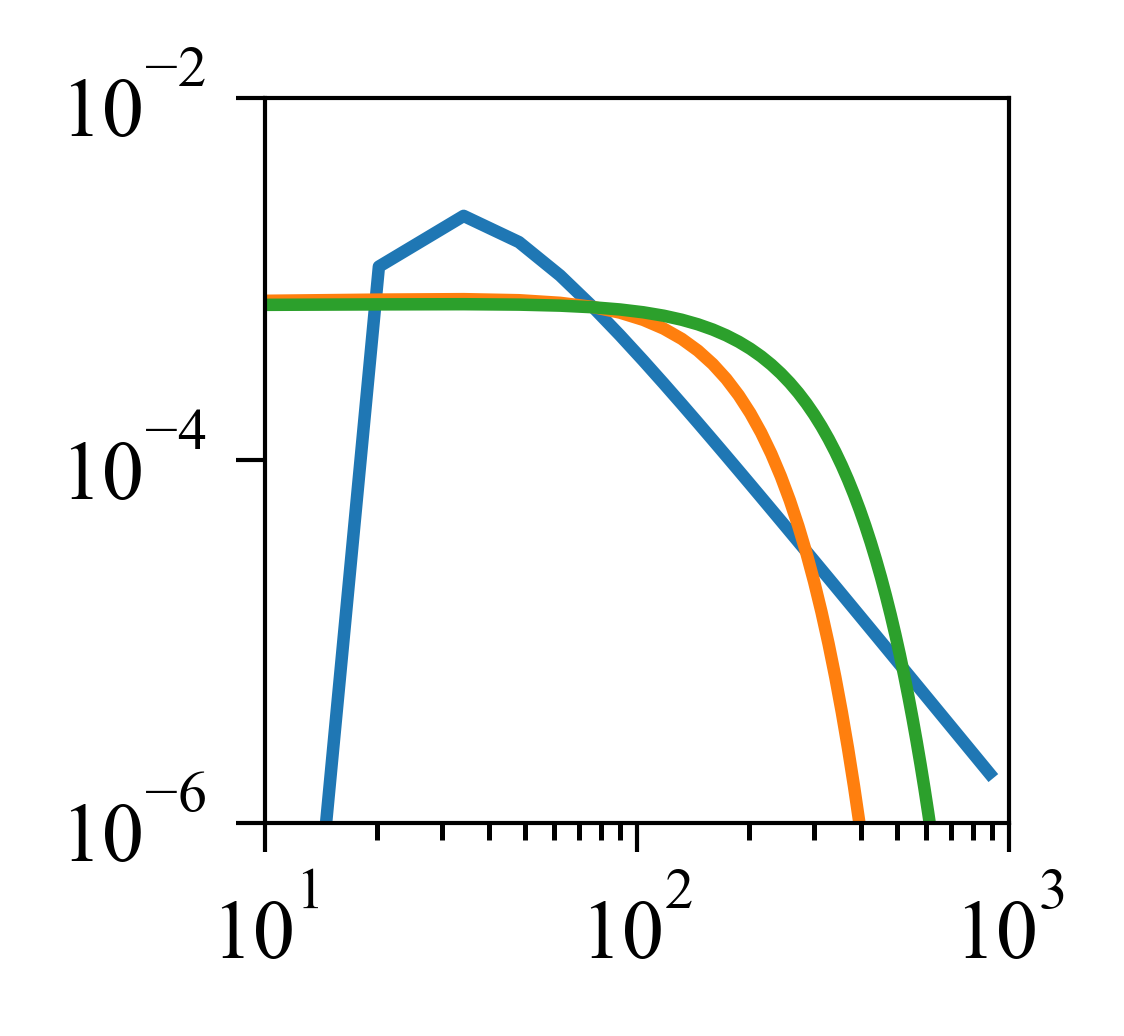

In [11]:
""" First initialization """
fig = plt.figure(figsize = [1.6,1.6]); ax = plt.gca()

kp=2*np.pi/40; L=200; P=0.02; N_power=5
N_mode = 32; # Uniform grid in kx and ky : how many we want to put in the initialization
N_kmod = 64; N_theta = 64 # Uniform grid in kmod and ktheta, can be finer than N_mode 
thetam = 0 # midline direction
kmod = np.linspace(2*np.pi/L,1.41*100*2*np.pi/L,N_kmod) # Change 
theta = np.linspace(-0.5*np.pi, 0.5*np.pi, N_theta) + thetam # Centered around thetam
kmod_tile, theta_tile = np.meshgrid(kmod,theta)

F_kmod = spectrum_PM(P, kp, kmod)
plt.plot(kmod*L, F_kmod*kp**3)
F_kmod = spectrum_Gaussian(0.1, 0.5, kp, kmod)
plt.plot(kmod*L, F_kmod*kp**3)
F_kmod = spectrum_Gaussian(0.15, 0.8, kp, kmod)
plt.plot(kmod*L, F_kmod*kp**3)

plt.yscale('log')
plt.xscale('log')

ax.set_xlim([10,1000])
ax.set_ylim([10**(-6.),10**(-2)])


mu = 0.0755851
kp*Hs = 0.304841


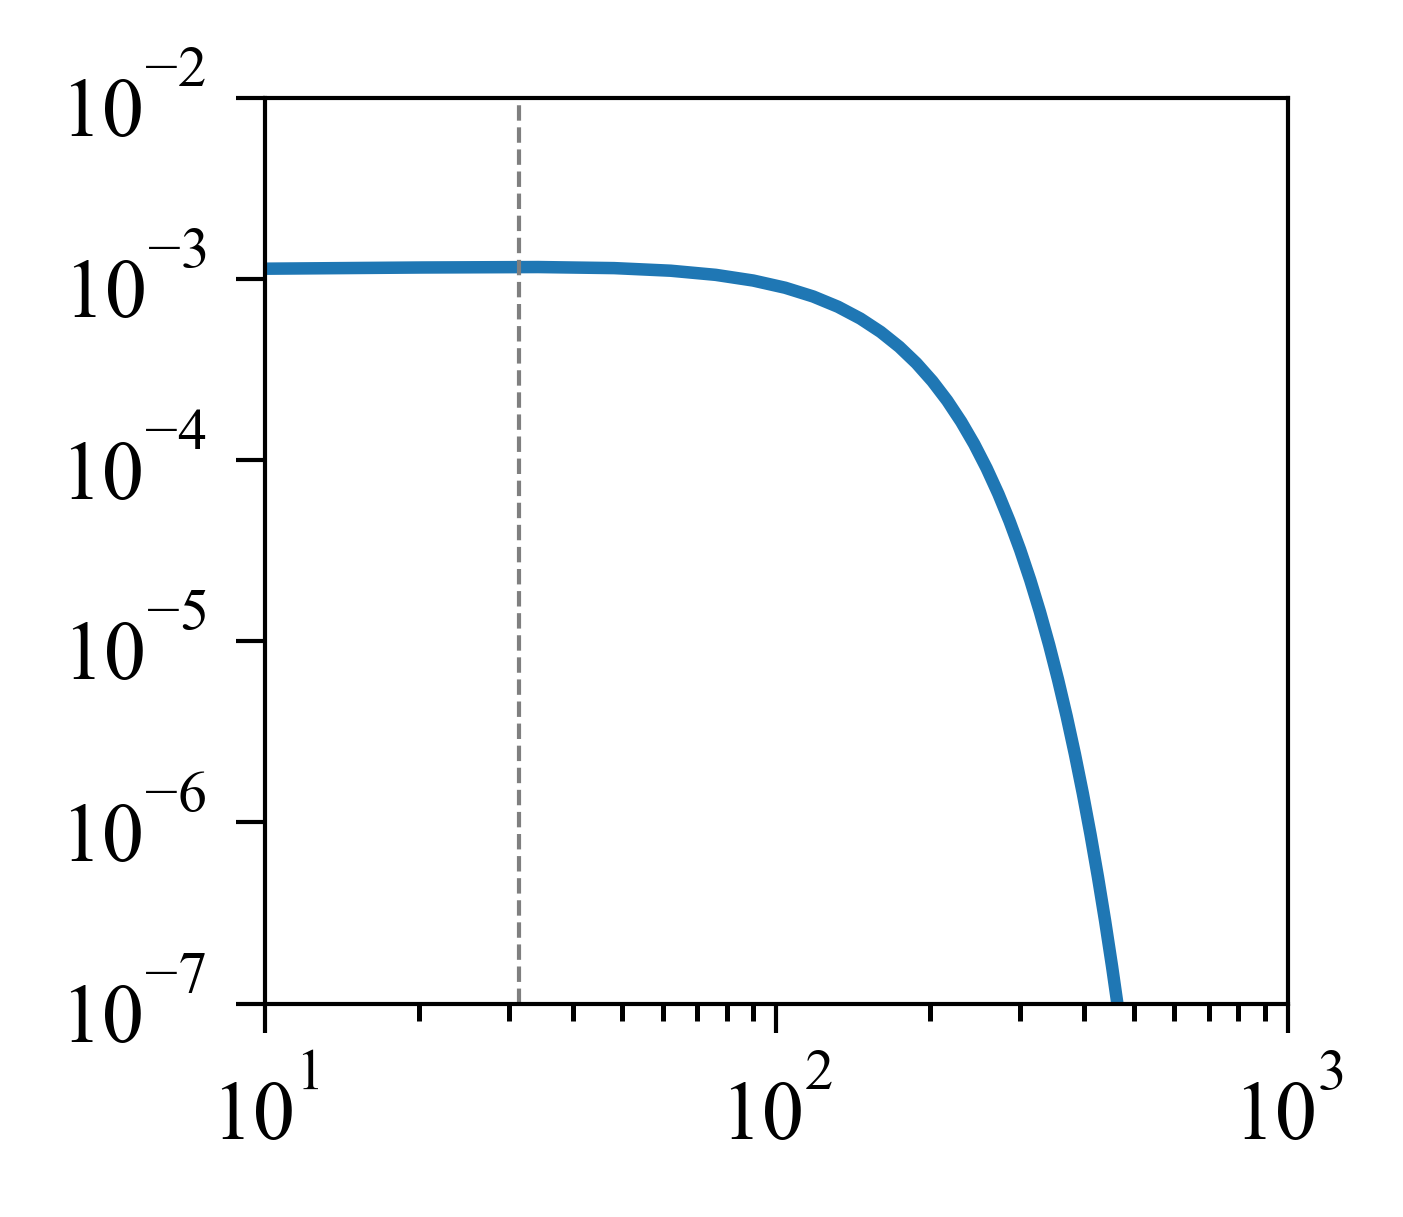

In [37]:
""" Output F_kxky 200m case Gaussian """
def spectrum_gen_Gaussian (kp=2*np.pi/100, G=0.5, span=0.1, L=200, N_power=5):
    N_mode = 32; # Uniform grid in kx and ky : how many we want to put in the initialization
    N_kmod = 64; N_theta = 64 # Uniform grid in kmod and ktheta, can be finer than N_mode 
    thetam = 0 # midline direction
    kmod = np.linspace(2*np.pi/L,1.41*100*2*np.pi/L,N_kmod) # Change 
    theta = np.linspace(-0.5*np.pi, 0.5*np.pi, N_theta) + thetam # Centered around thetam
    kmod_tile, theta_tile = np.meshgrid(kmod,theta)
    """ Gaussian """
    F_kmod = spectrum_Gaussian(G, span, kp, kmod)
    D_theta = np.abs(np.cos(theta-thetam)**N_power)
    dtheta = theta[1]-theta[0]
    """ Is this necessary? Yes! """
    D_theta = D_theta/np.trapz(D_theta, theta)  # Normalize so the sum equals one
    F_kmod_tile, D_theta_tile = np.meshgrid(F_kmod,D_theta) 
    F_kmodtheta_tile = F_kmod_tile*D_theta_tile/kmod_tile # Notice!! Normalize by k
    """ Uniform grid in kx,ky """
    kx = np.arange(1,N_mode+1)*2*np.pi/L # based on the grid, interval can't go smaller then pi/L
    ky = np.arange(-N_mode/2,N_mode/2+1)*2*np.pi/L
    kx_tile, ky_tile = np.meshgrid(kx,ky)
    kxp_tile, kyp_tile = pol2cart(kmod_tile, theta_tile)
    """ Project from uniform k to uniform kx,ky """
    F_kxky_tile = griddata((kxp_tile.ravel(), kyp_tile.ravel()), F_kmodtheta_tile.ravel(), (kx_tile, ky_tile), 
                            method='linear', fill_value=0) # Interpolate from kxp,kyp (uniform in k) to kx,ky (uniform in kx,ky)
    return kmod, F_kmod, kx, ky, F_kxky_tile

kp = 2*np.pi/40 # peak at 40m
G = 0.15
span = 0.5
kmod, F_kmod, kx, ky, F_kxky_tile = spectrum_gen_Gaussian(kp, G, span, L=200)
kx_tile, ky_tile = np.meshgrid(kx,ky)

mu,Hs = steepness_trunc_non_uniform (F_kmod, kmod)
print('mu = %g' %mu[-1])
print('kp*Hs = %g' %(4*kp*Hs[-1]))

fig = plt.figure(figsize = [2.2,2])
plt.plot(kmod*L, F_kmod*kp**3)
ax = plt.gca()

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim([10,1000])
ax.set_ylim([10**(-7.),10**(-2.)])

ax.axvline(2*np.pi/(L/5)*L,ls='--',color='C7',lw=0.5)
ax.set_yticks([10**(-7), 10**(-6), 10**(-5), 10**(-4), 10**(-3), 10**(-2)])

fF = open("/projects/DEIKE/jiarongw/multilayer/F_kxky_GaussianG015S05_200m", 'bw')
F_output = F_kxky_tile.astype('float32'); F_output.tofile(fF)

In [25]:
N_grid = 1024
x = np.linspace(-L/2,L/2,N_grid); y = np.linspace(-L/2,L/2,N_grid)
x_tile, y_tile = np.meshgrid(x, y)

kmod_cart_tile, theta_cart_tile = cart2pol(kx_tile,ky_tile)
omega_tile = (9.8*kmod_cart_tile)**0.5 # frequency based on kx or kmod
dkx = kx_tile[0,1]-kx_tile[0,0]; dky = ky_tile[1,0]-ky_tile[0,0]

eta_tile, phase_tile = eta_random(0, N_grid, kx_tile, ky_tile, F_kxky_tile, dkx, dky, omega_tile)

Text(0.5, 0, 'kx')

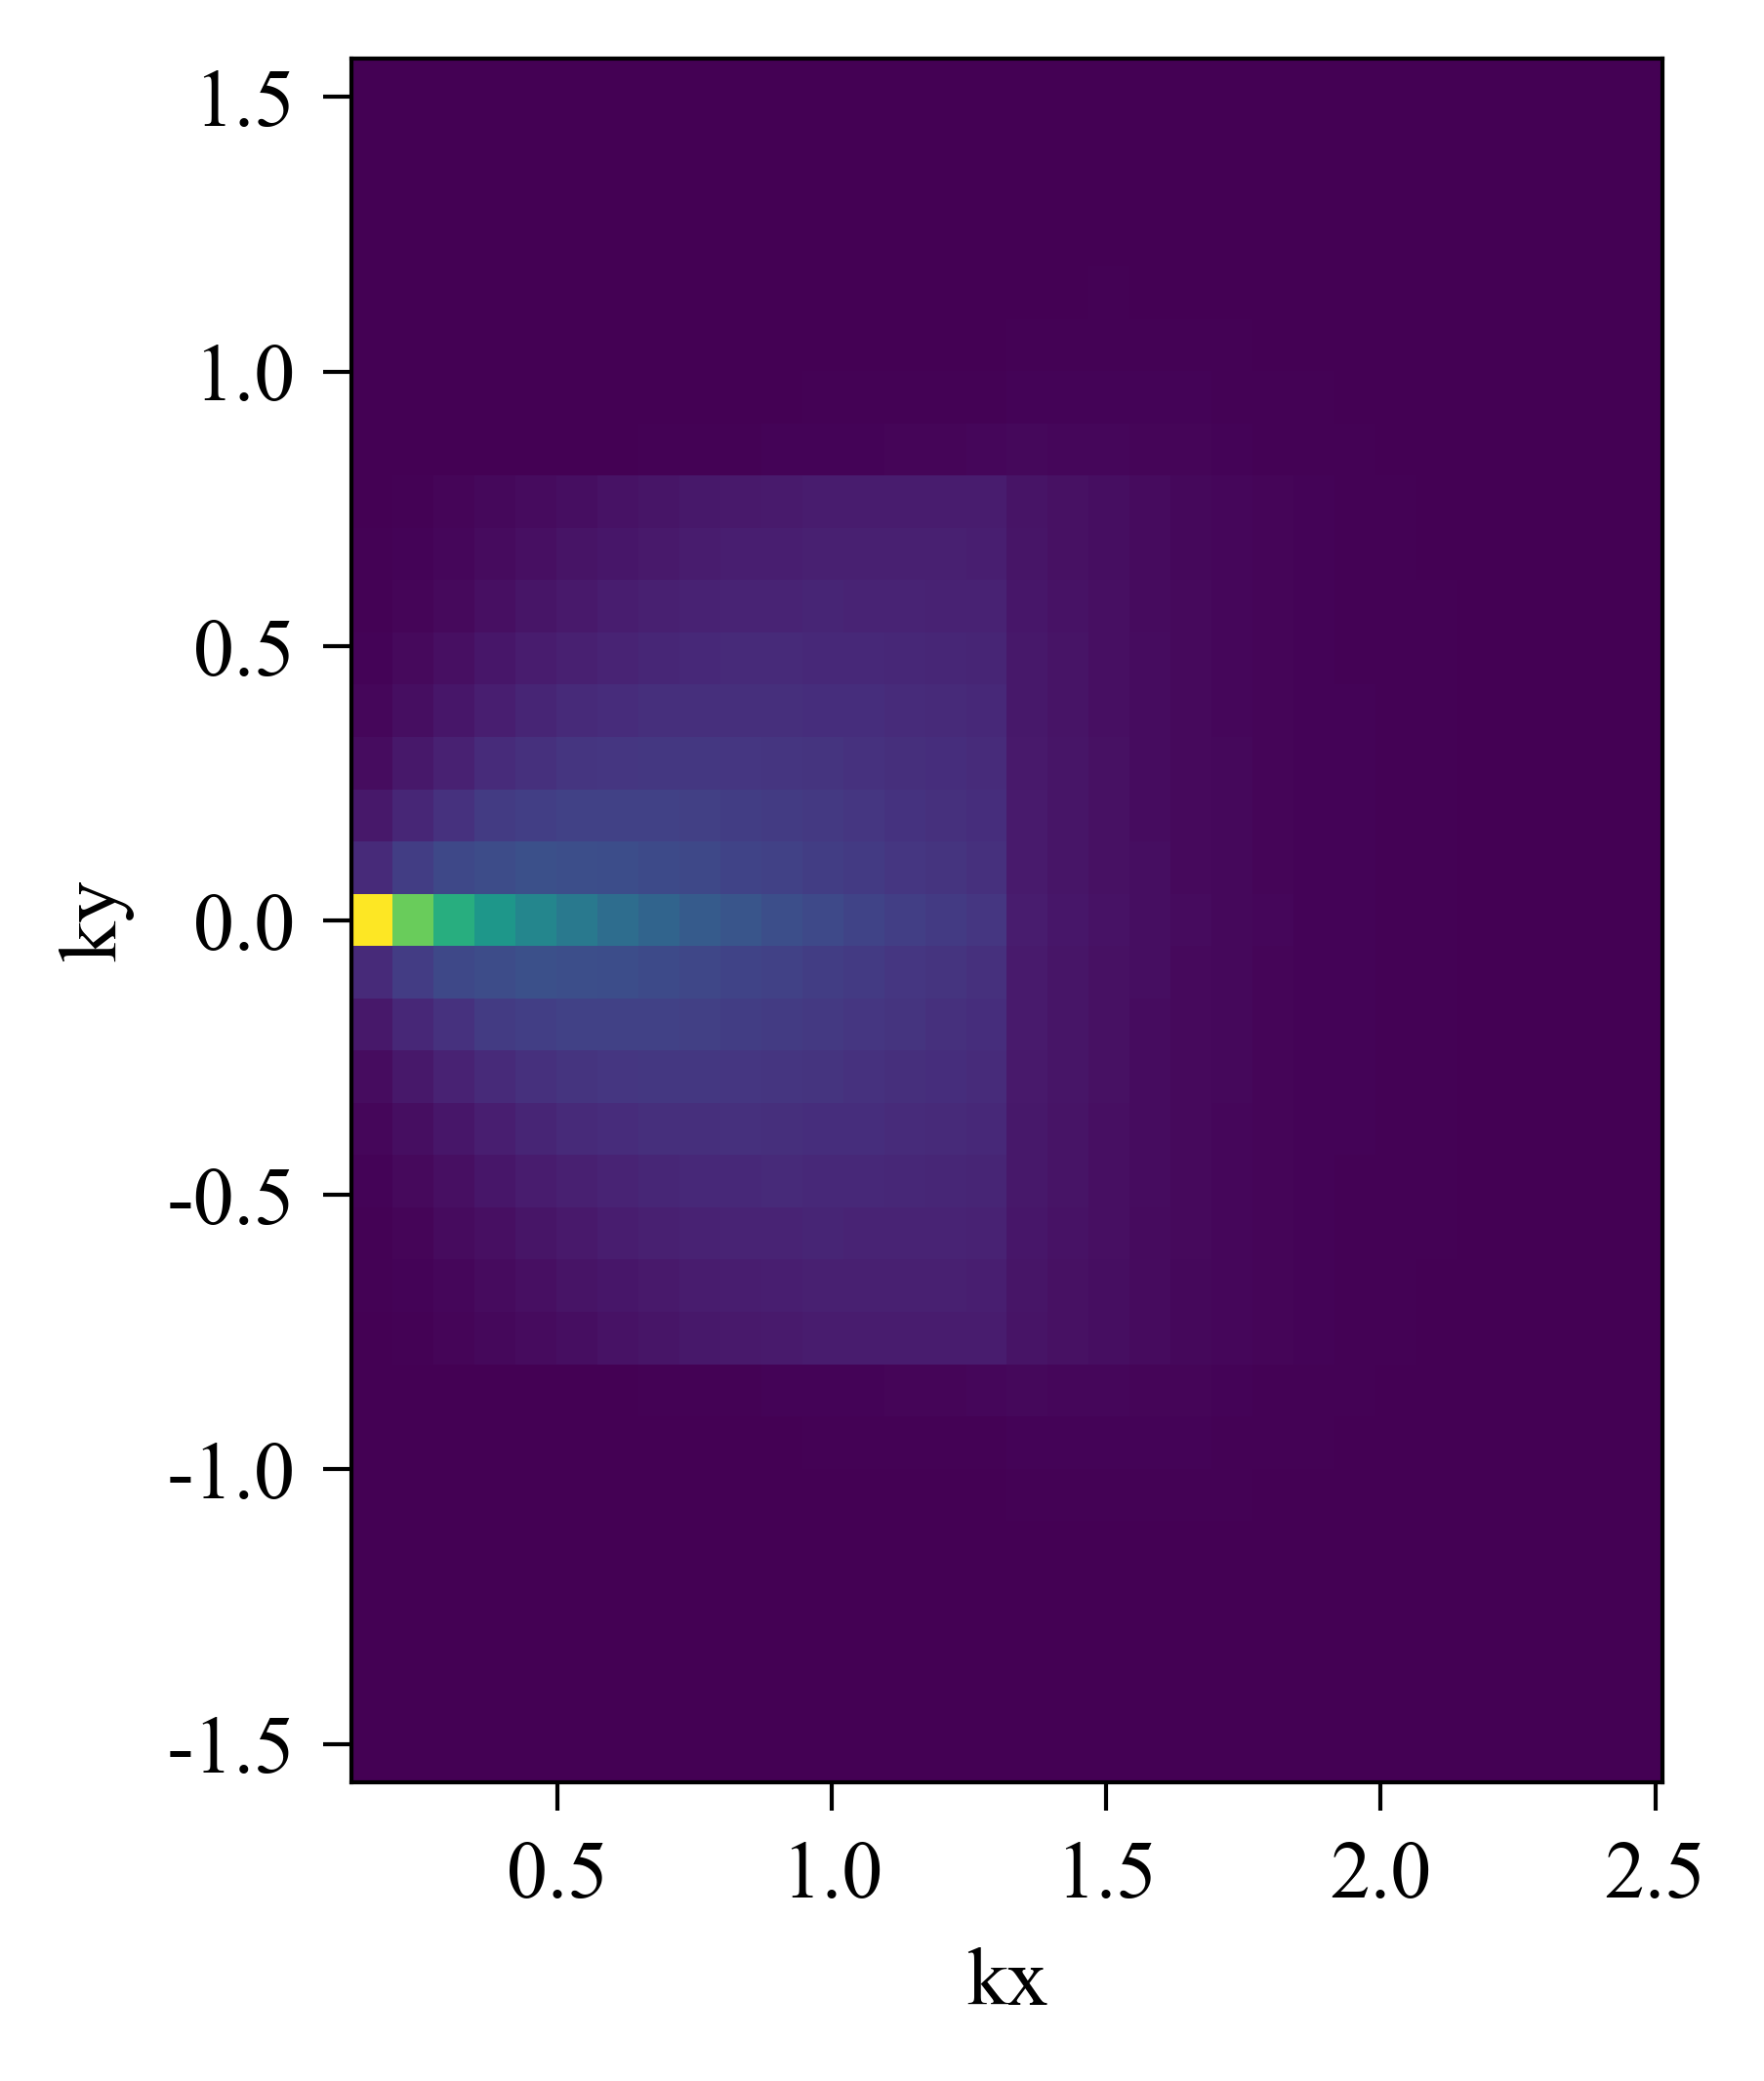

In [29]:
# Spectrum for L0 = 200
plt.imshow(F_kxky_tile, extent=[kx_tile[0,0],kx_tile[-1,-1],ky_tile[0,0],ky_tile[-1,-1]])
plt.ylabel('ky'); plt.xlabel('kx')

In [ ]:
def spectrum_gen (kp=2*np.pi/100, P=0.45, L=500, N_power=5):
    N_mode = 32; # Uniform grid in kx and ky : how many we want to put in the initialization
    N_kmod = 64; N_theta = 64 # Uniform grid in kmod and ktheta, can be finer than N_mode 
    thetam = 0 # midline direction
    kmod = np.linspace(2*np.pi/L,1.41*100*2*np.pi/L,N_kmod) # Change 
    theta = np.linspace(-0.5*np.pi, 0.5*np.pi, N_theta) + thetam # Centered around thetam
    kmod_tile, theta_tile = np.meshgrid(kmod,theta)
    """ JONSWAP without shape modification gamma """
    F_kmod = P*kmod**(-2.5)*np.exp(-1.25*(kp/kmod)**2)
    D_theta = np.abs(np.cos(theta-thetam)**N_power)
    dtheta = theta[1]-theta[0]
    """ Is this necessary? Yes! """
    D_theta = D_theta/np.trapz(D_theta, theta)  # Normalize so the sum equals one
    F_kmod_tile, D_theta_tile = np.meshgrid(F_kmod,D_theta) 
    F_kmodtheta_tile = F_kmod_tile*D_theta_tile/kmod_tile # Notice!! Normalize by k
    """ Uniform grid in kx,ky """
    kx1 = np.linspace(4*2*np.pi/L,20*2*np.pi/L,int(N_mode/2)) 
    kx2 = np.linspace(30*2*np.pi/L,80*2*np.pi/L,int(N_mode/2)) 
    kx = np.concatenate((kx1,kx2))
    ky1 = np.linspace(-50*2*np.pi/L,-20*2*np.pi/L, int(N_mode/4))
    ky2 = np.linspace(-10*2*np.pi/L,-4*2*np.pi/L, int(N_mode/4))
    ky = np.concatenate((ky1, ky2, [0], -ky2[::-1], -ky1[::-1]))
    kx_tile, ky_tile = np.meshgrid(kx,ky)
    kxp_tile, kyp_tile = pol2cart(kmod_tile, theta_tile)
    """ Project from uniform k to uniform kx,ky """
    F_kxky_tile = griddata((kxp_tile.ravel(), kyp_tile.ravel()), F_kmodtheta_tile.ravel(), (kx_tile, ky_tile), 
                            method='linear', fill_value=0) # Interpolate from kxp,kyp (uniform in k) to kx,ky (uniform in kx,ky)
    return kmod, F_kmod, kx, ky, F_kxky_tile

For reproduction purpose: original code for the jfm rapids paper
```
def spectrum_gen(kp=2*np.pi/100, P=0.45, L=500, N_power=5):
    thetam = 0
    N_mode = 32; # Uniform grid in kx and ky : how many we want to put in the initialization
    N_kmod = 64; N_theta = 64 # Uniform grid in kmod and ktheta
    kmod = np.linspace(2*np.pi/L,1.5*N_mode*2*np.pi/L,N_kmod); theta = np.linspace(-0.5*np.pi, 0.5*np.pi, N_theta)
    kmod_tile, theta_tile = np.meshgrid(kmod,theta)
    """ JONSWAP without shape modification gamma """
    F_kmod = P*kmod**(-2.5)*np.exp(-1.25*(kp/kmod)**2)
    D_theta = np.cos(theta-thetam)**N_power
    dtheta = theta[1]-theta[0]
    """ Is this necessary? Yes! """
    D_theta = D_theta/np.trapz(D_theta, theta)  # Normalize so the sum equals one
    F_kmod_tile, D_theta_tile = np.meshgrid(F_kmod,D_theta) 
    F_kmodtheta_tile = F_kmod_tile*D_theta_tile/kmod_tile # Notice!! Normalize by k
    """ Uniform grid in kx,ky """
    kx = np.arange(1,N_mode+1)*2*np.pi/L # based on the grid, interval can't go smaller then pi/L
    ky = np.arange(-N_mode/2,N_mode/2+1)*2*np.pi/L
    kx_tile, ky_tile = np.meshgrid(kx,ky)
    kxp_tile, kyp_tile = pol2cart(kmod_tile, theta_tile)
    """ Project from uniform k to uniform kx,ky """
    F_kxky_tile = griddata((kxp_tile.ravel(), kyp_tile.ravel()), F_kmodtheta_tile.ravel(), (kx_tile, ky_tile), 
                            method='linear', fill_value=0) # Interpolate from kxp,kyp (uniform in k) to kx,ky (uniform in kx,ky)
    return kmod, F_kmod, kx, ky, F_kxky_tile
```

In [86]:
# def spectrum_gen_bimodal(kp=2*np.pi/100, P=0.45, L=500, N_power=5):
#     N_mode = 32; # Uniform grid in kx and ky : how many we want to put in the initialization
#     N_kmod = 64; N_theta = 64 # Uniform grid in kmod and ktheta, can be finer than N_mode 
#     kmod = np.logspace(np.log(2*np.pi/L*2),np.log(1.41*100*2*np.pi/L),N_kmod) # Change 
#     theta = np.linspace(-0.5*np.pi, 0.5*np.pi, N_theta)
#     kmod_tile, theta_tile = np.meshgrid(kmod,theta)
#     """ JONSWAP without shape modification gamma """
#     F_kmod1 = P*kmod**(-2.5)*np.exp(-1.25*(kp/kmod)**2)
#     thetam = np.pi/6 # midline direction
#     D_theta = np.abs(np.cos(theta-thetam)**N_power)
#     dtheta = theta[1]-theta[0]
#     """ Is this necessary? Yes! """
#     D_theta = D_theta/np.trapz(D_theta, theta)  # Normalize so the sum equals one
#     F_kmod_tile, D_theta_tile = np.meshgrid(F_kmod,D_theta) 
#     F_kmodtheta_tile = F_kmod_tile*D_theta_tile/kmod_tile # Notice!! Normalize by k
#     """ Uniform (in log) grid in kx,ky """
#     kx = np.logspace(np.log10(2*np.pi/L),np.log10(200*2*np.pi/L),N_mode) # based on the grid, interval can't go smaller then pi/L
#     ky1 = np.logspace(np.log10(2*np.pi/L),np.log10(100*2*np.pi/L), int(N_mode/2))
#     ky2 = -ky1[::-1]
#     ky = np.concatenate((ky2,[0],ky1))
#     kx_tile, ky_tile = np.meshgrid(kx,ky)
#     kxp_tile, kyp_tile = pol2cart(kmod_tile, theta_tile)
#     """ Project from uniform k to uniform kx,ky """
#     F_kxky_tile1 = griddata((kxp_tile.ravel(), kyp_tile.ravel()), F_kmodtheta_tile.ravel(), (kx_tile, ky_tile), 
#                             method='linear', fill_value=0) # Interpolate from kxp,kyp (uniform in k) to kx,ky (uniform in kx,ky)
#     """ Wind wave part """
#     F_kmod2 = P*400*kmod**(-3)*np.exp(-2.5*(kp*10/kmod)**2) 
#     thetam = 45
#     D_theta = np.abs(np.cos(theta-thetam))**N_power
#     dtheta = theta[1]-theta[0]
#     F_kmod_tile, D_theta_tile = np.meshgrid(F_kmod2,D_theta) 
#     F_kmodtheta_tile = F_kmod_tile*D_theta_tile/kmod_tile # Notice!! Normalize by k
#     """ Project from uniform k to uniform kx,ky """
#     F_kxky_tile2 = griddata((kxp_tile.ravel(), kyp_tile.ravel()), F_kmodtheta_tile.ravel(), (kx_tile, ky_tile), 
#                             method='linear', fill_value=0) # Interpolate from kxp,kyp (uniform in k) to kx,ky (uniform in kx,ky)
#     return kmod, F_kmod1+F_kmod2, kx, ky, F_kxky_tile1+F_kxky_tile2

def spectrum_gen_bimodal(kp=2*np.pi/100, P=0.45, L=500, N_power=5):
    N_mode = 32; # Uniform grid in kx and ky : how many we want to put in the initialization
    N_kmod = 64; N_theta = 64 # Uniform grid in kmod and ktheta, can be finer than N_mode 
    kmod = np.linspace(2*np.pi/L,1.41*100*2*np.pi/L,N_kmod) # Change 
    theta = np.linspace(-0.5*np.pi, 0.5*np.pi, N_theta)
    kmod_tile, theta_tile = np.meshgrid(kmod,theta)
    """ JONSWAP without shape modification gamma """
    F_kmod1 = P*kmod**(-2.5)*np.exp(-1.25*(kp/kmod)**2)
    thetam = 0 # midline direction
    D_theta = np.abs(np.cos(theta-thetam)**N_power)
    dtheta = theta[1]-theta[0]
    """ Is this necessary? Yes! """
    D_theta = D_theta/np.trapz(D_theta, theta)  # Normalize so the sum equals one
    F_kmod_tile, D_theta_tile = np.meshgrid(F_kmod,D_theta) 
    F_kmodtheta_tile = F_kmod_tile*D_theta_tile/kmod_tile # Notice!! Normalize by k
    """ Uniform (in log) grid in kx,ky """
    kx1 = np.linspace(4*2*np.pi/L,20*2*np.pi/L,int(N_mode/2)) 
    kx2 = np.linspace(30*2*np.pi/L,80*2*np.pi/L,int(N_mode/2)) 
    kx = np.concatenate((kx1,kx2))
    ky1 = np.linspace(-50*2*np.pi/L,-20*2*np.pi/L, int(N_mode/4))
    ky2 = np.linspace(-10*2*np.pi/L,-4*2*np.pi/L, int(N_mode/4))
    ky = np.concatenate((ky1, ky2, [0], -ky2[::-1], -ky1[::-1]))
    kx_tile, ky_tile = np.meshgrid(kx,ky)
    kxp_tile, kyp_tile = pol2cart(kmod_tile, theta_tile)
    """ Project from uniform k to uniform kx,ky """
    F_kxky_tile1 = griddata((kxp_tile.ravel(), kyp_tile.ravel()), F_kmodtheta_tile.ravel(), (kx_tile, ky_tile), 
                            method='linear', fill_value=0) # Interpolate from kxp,kyp (uniform in k) to kx,ky (uniform in kx,ky)
    """ Wind wave part """
    F_kmod2 = P*200*kmod**(-3)*np.exp(-2.5*(kp*8/kmod)**2) 
    thetam = np.pi/6
    D_theta = np.abs(np.cos(theta-thetam))**N_power
    dtheta = theta[1]-theta[0]
    F_kmod_tile, D_theta_tile = np.meshgrid(F_kmod2,D_theta) 
    F_kmodtheta_tile = F_kmod_tile*D_theta_tile/kmod_tile # Notice!! Normalize by k
    """ Project from uniform k to uniform kx,ky """
    F_kxky_tile2 = griddata((kxp_tile.ravel(), kyp_tile.ravel()), F_kmodtheta_tile.ravel(), (kx_tile, ky_tile), 
                            method='linear', fill_value=0) # Interpolate from kxp,kyp (uniform in k) to kx,ky (uniform in kx,ky)
    return kmod, F_kmod1+F_kmod2, kx, ky, F_kxky_tile1+F_kxky_tile2

In [7]:
""" Plot the polar spectrum 
    TODO: adjust the range and labeling when needed! """
def make_polar_plot(thetas, radii, F_rtheta):
    plt.clf()
    fig = plt.figure(figsize=[5,5])
    ax = fig.add_axes([0.1,0.1,0.8,0.8],polar=True)
    vmax=1; vmin=-2
    img = ax.pcolormesh(thetas, radii, np.rot90(F_rtheta)[::-1,:], edgecolors='white', lw=0.1, cmap='PuRd', vmax=vmax, vmin=vmin)
    cbar = fig.colorbar(img, orientation="vertical", fraction=0.046, pad=0.1, ticks=[-2,-1,0,1])
    cbar.ax.set_yticklabels(['$10^{-2}$','$10^{-1}$','$10^{-0}$','$10^{1}$'])
    cbar.ax.text(0.5, 1.05, r'$F(k,\theta) [m^3 rad^{-1}]$', ha='center', va='center', transform=cbar.ax.transAxes)
    return ax

def make_cartesian_plot(xs, ys, F_xy):
    plt.clf()
    fig = plt.figure(figsize=[5,5])
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    ax.pcolormesh(xs, ys, F_xy, edgecolors='face')
    return x

In [8]:
""" Compute the cumulative steepness """
def steepness_trunc_non_uniform (F,k):
    mu = np.zeros(len(k))
    Hs = np.zeros(len(k))
    dk = np.roll(k, -1) - k
    dk = np.array(dk); dk[-1]=0
    for i,k_ in enumerate(k):
        mu[i] = np.sum(k[:i]**2*F[:i]*dk[:i])
        Hs[i] = np.sum(F[:i]*dk[:i])**0.5
    return mu, Hs

In [24]:
'''
    Add modes together to generate initial eta field. Random phase.
'''

def eta_random(t, N_grid, kx_tile, ky_tile, F_kxky_tile, dkx, dky, omega_tile):
    # This is the only place that the random field is generated, everything else should agree;
    # and we want to seed the random number
    global x_tile, y_tile
    np.random.seed(0) 
    tb = 40; xb = 0; yb = 0
    phase_tile = -kx_tile*xb-ky_tile*yb+np.random.random_sample(kx_tile.shape)*2*np.pi # Add a random phase field
    #phase_tile = -kx_tile*xb-ky_tile*yb+omega_tile*tb+np.random.random_sample(kx_tile.shape)*5 # Add a random phase field
    eta_tile = np.zeros(x_tile.shape)
    for i1 in range(0,N_grid):
        for i2 in range(0,N_grid):
            ampl = (2*F_kxky_tile*dkx*dky)**0.5
            # How to exactly represent integrate over dk_x*dk_y*eta_hat?
            # mode = (F_kdirectional**0.5)*np.cos((kx_tile*x_tile[i1,i2]+ky_tile*y_tile[i1,i2])+
            #                                    phase_tile)*(kmod_tile*(kmod[1]-kmod[0])*(theta[1]-theta[0])) # uniform space in k and theta
            a = (kx_tile*x_tile[i1,i2]+ky_tile*y_tile[i1,i2])-omega_tile*t+phase_tile
            mode = ampl*(np.cos(a)) # uniform spacing in kx and ky
            eta_tile[i1,i2] = np.sum(mode)    
    return eta_tile, phase_tile

mu = 0.0316758
kp*Hs = 0.181142


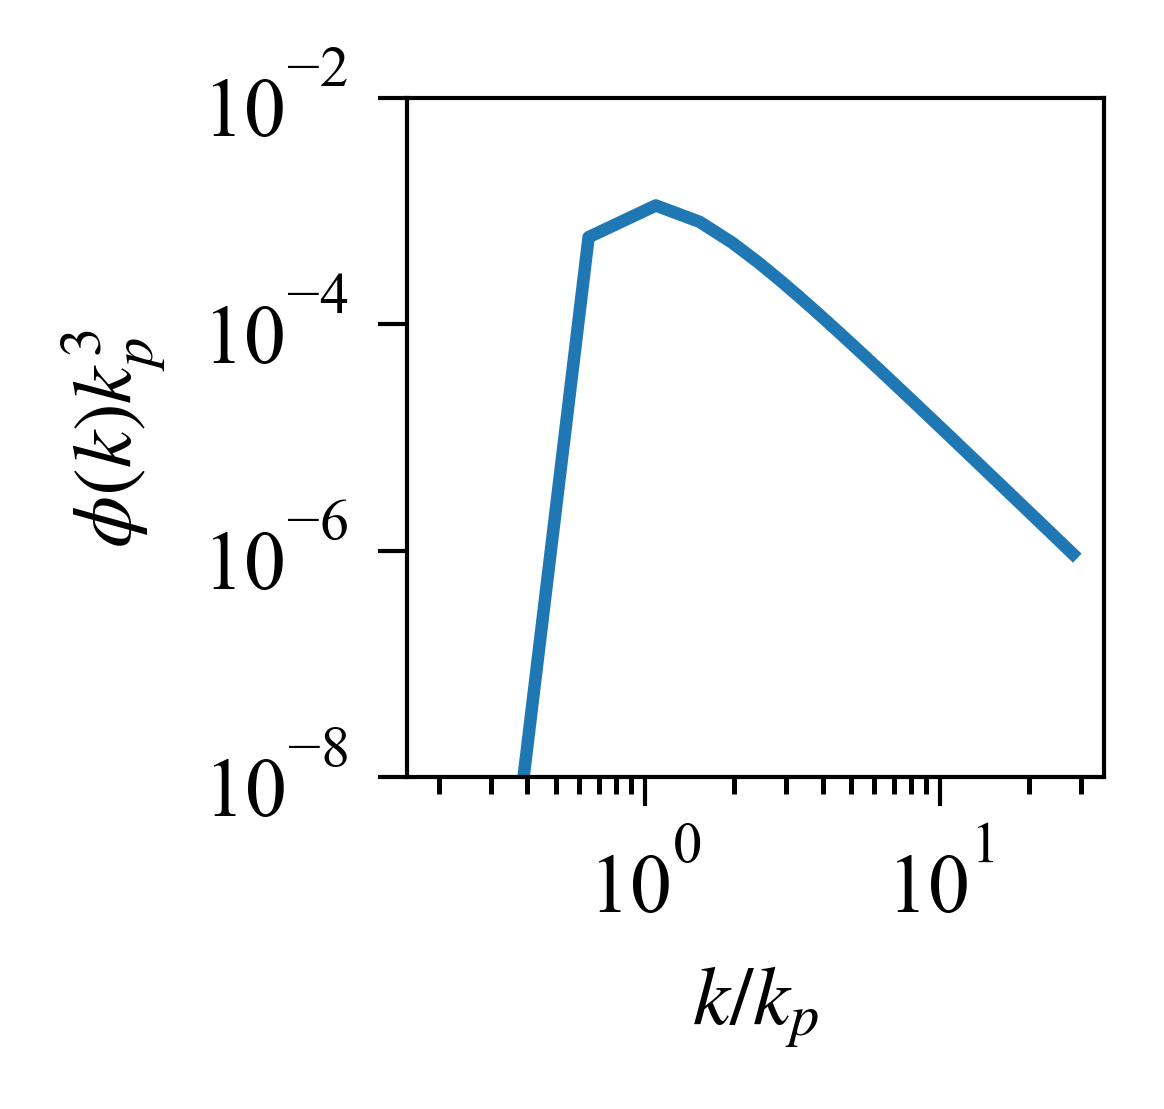

In [103]:
""" Single mode spectrum """
''' Check kp*Hs, 200m, alter '''
fig = plt.figure (figsize=[1.5,1.5])

kp = 2*np.pi/40 # peak at 40m
P = 0.010
kmod, F_kmod, kx, ky, F_kxky_tile = spectrum_gen(kp, P, L=200)
kx_tile, ky_tile = np.meshgrid(kx,ky)

mu,Hs = steepness_trunc_non_uniform (F_kmod, kmod)
print('mu = %g' %mu[-1])
print('kp*Hs = %g' %(4*kp*Hs[-1]))

plt.plot(kmod/kp, F_kmod*kp**3)

plt.ylim([5*10**(-1), 10**(2)])
plt.ylim([10**(-8), 10**(-2)])
plt.xlabel(r'$k/k_p$'); plt.ylabel(r'$\phi(k)k_p^3$')
plt.xscale('log'); plt.yscale('log')


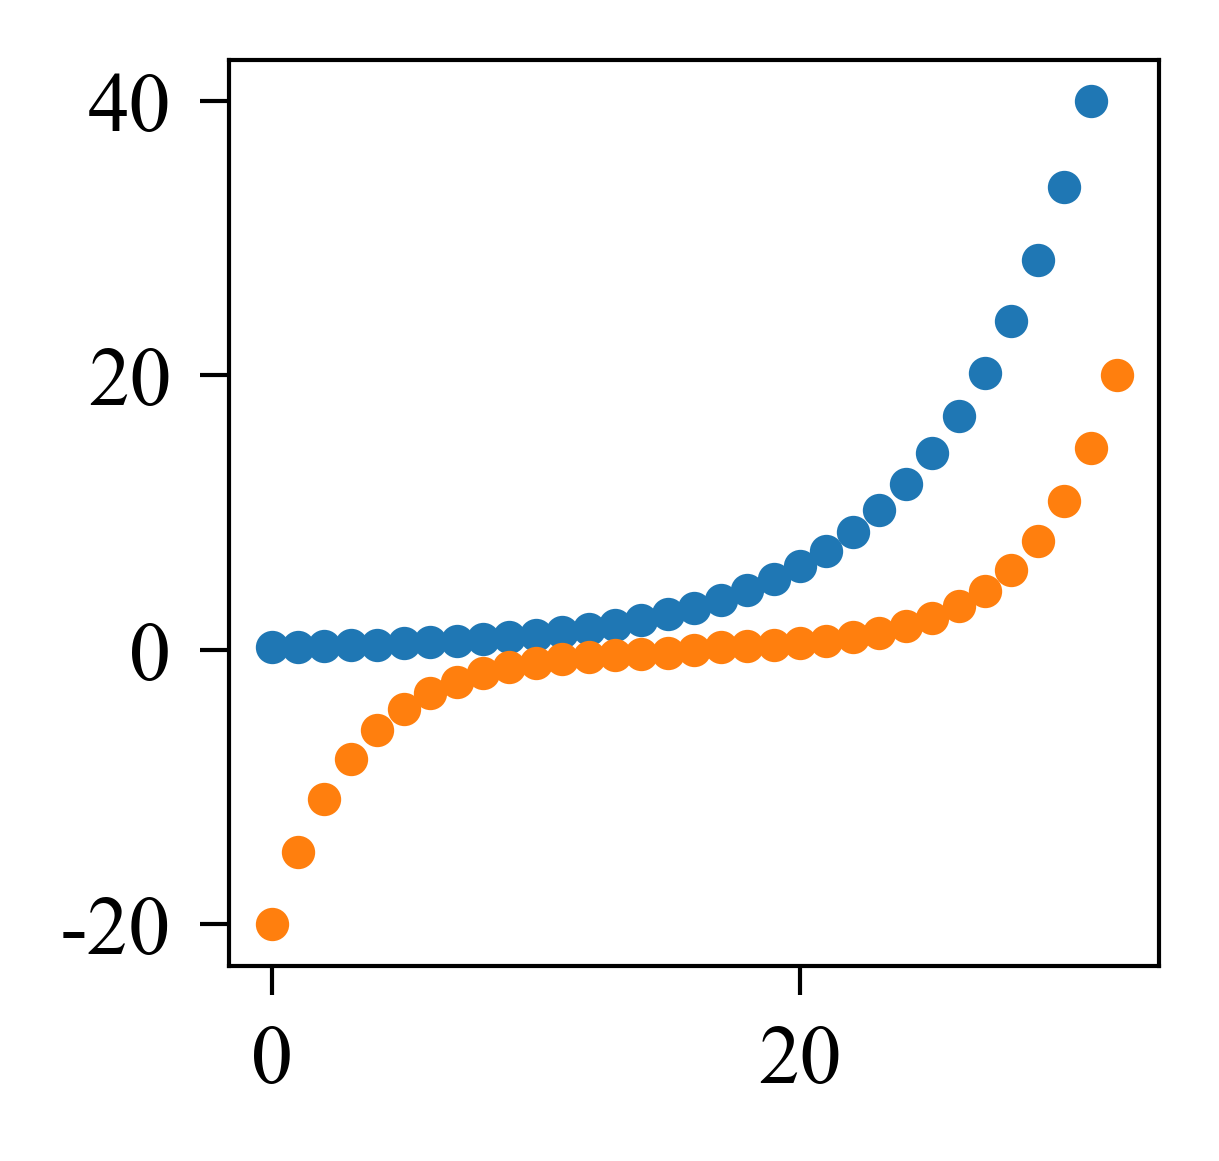

In [32]:
""" Log spaced """
fig = plt.figure(figsize=[2,2])
N_mode = 32
L = 200
kx = np.logspace(np.log10(2*np.pi/L),np.log10(200*2*np.pi/L),N_mode) # based on the grid, interval can't go smaller then pi/L
plt.plot(kx/kp, '.')
ky1 = np.logspace(np.log10(2*np.pi/L),np.log10(100*2*np.pi/L), int(N_mode/2))
ky2 = -ky1[::-1]
ky = np.concatenate((ky2,[0],ky1))
plt.plot(ky/kp, '.')

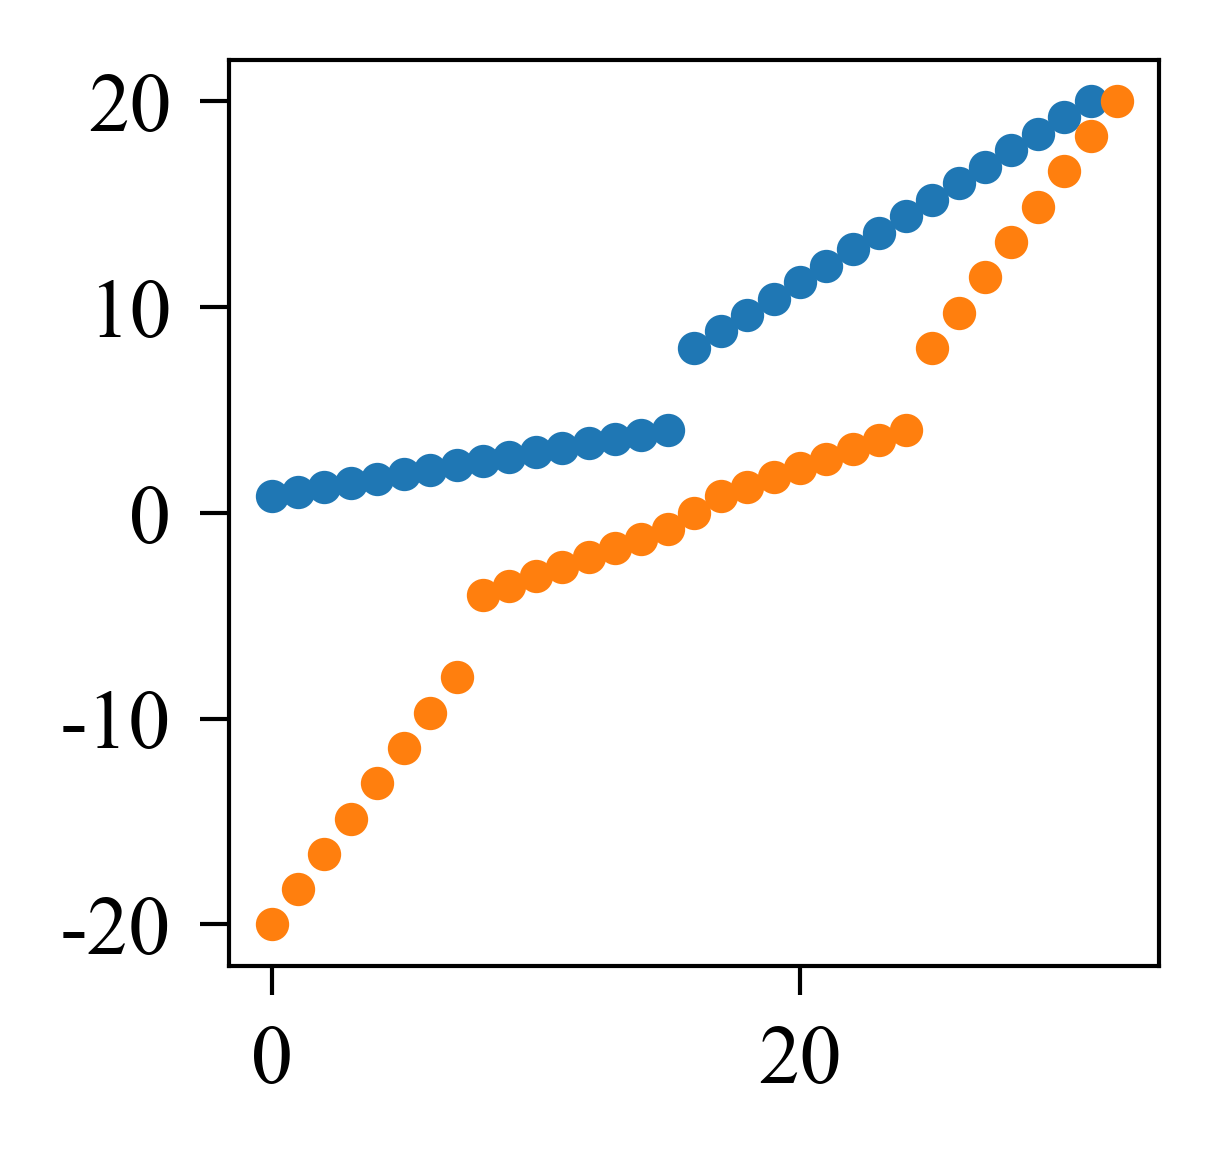

In [43]:
""" Linear spaced"""
kx1 = np.linspace(4*2*np.pi/L,20*2*np.pi/L,int(N_mode/2)) 
kx2 = np.linspace(40*2*np.pi/L,100*2*np.pi/L,int(N_mode/2)) 
kx = np.concatenate((kx1,kx2))
ky1 = np.linspace(-100*2*np.pi/L,-40*2*np.pi/L, int(N_mode/4))
ky2 = np.linspace(-20*2*np.pi/L,-4*2*np.pi/L, int(N_mode/4))
ky = np.concatenate((ky1, ky2, [0], -ky2[::-1], -ky1[::-1]))
fig = plt.figure(figsize=[2,2])
plt.plot(kx/kp, '.')
plt.plot(ky/kp, '.')

mu = 0.358595
kp*Hs = 0.182084


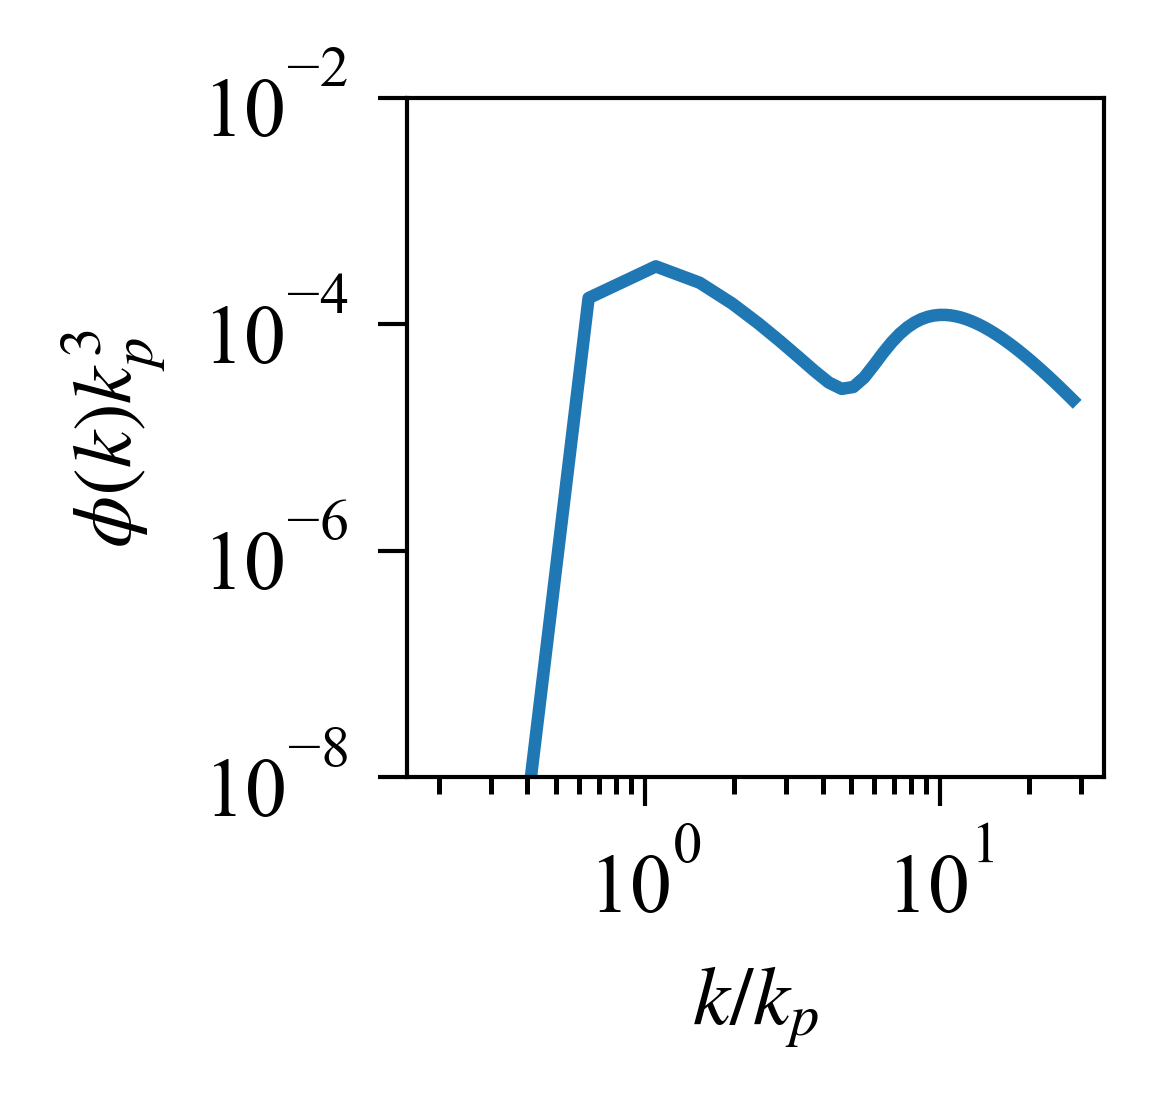

In [108]:
""" Single mode spectrum """
''' Check kp*Hs, 200m, alter '''

fig = plt.figure (figsize=[1.5,1.5])

kp = 2*np.pi/40 # peak at 40m
P = 0.0029
kmod, F_kmod, kx, ky, F_kxky_tile = spectrum_gen_bimodal(kp, P, L=200)
kx_tile, ky_tile = np.meshgrid(kx,ky)

mu,Hs = steepness_trunc_non_uniform (F_kmod, kmod)
print('mu = %g' %mu[-1])
print('kp*Hs = %g' %(4*kp*Hs[-1]))

plt.plot(kmod/kp, F_kmod*kp**3)

plt.ylim([5*10**(-1), 10**(2)])
plt.ylim([10**(-8), 10**(-2)])
plt.xlabel(r'$k/k_p$'); plt.ylabel(r'$\phi(k)k_p^3$')
plt.xscale('log'); plt.yscale('log')

""" Output F_kxky 200m case alter """
fF = open("/projects/DEIKE/jiarongw/multilayer/F_kxky_bimodal1_200m", 'bw')
F_output = F_kxky_tile.astype('float32'); F_output.tofile(fF)

Text(0.5, 0, '$k_x/k_p$')

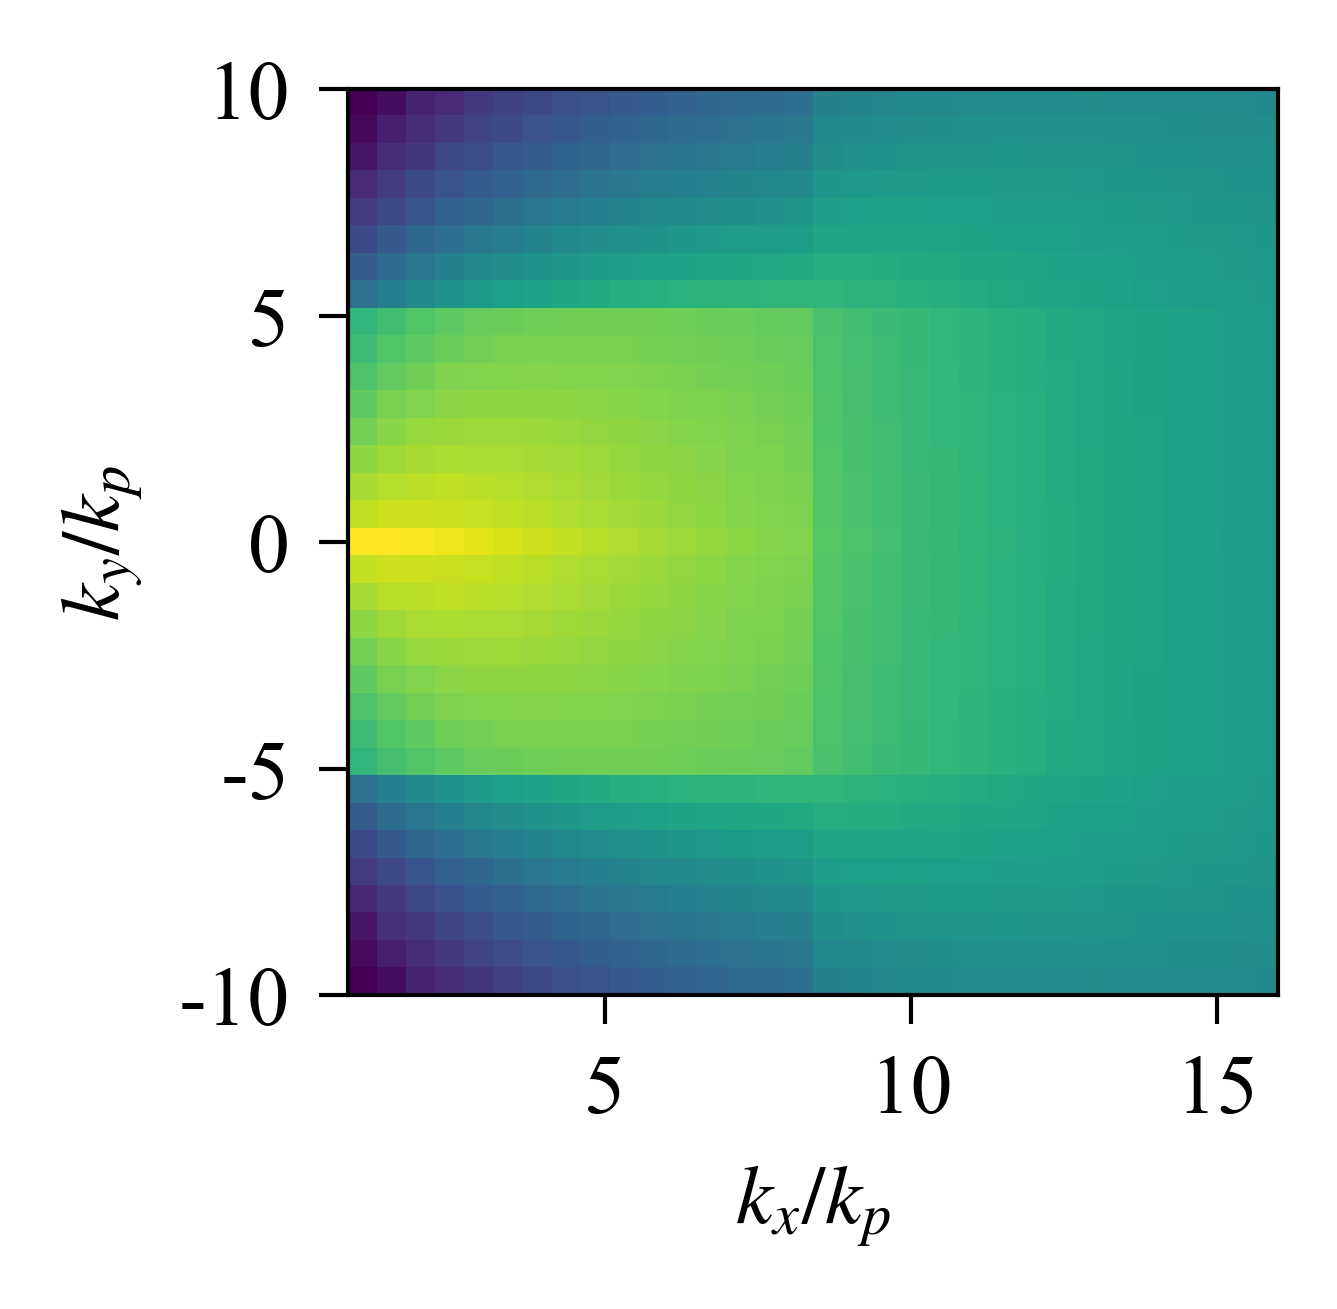

In [107]:
fig = plt.figure(figsize=[2,2])
kx_tile, ky_tile = np.meshgrid(kx,ky)
kp = 2*np.pi/40
# Some visualization:
plt.imshow(np.log(F_kxky_tile/F_kxky_tile.max()), extent=[kx_tile[0,0]/kp,kx_tile[-1,-1]/kp,ky_tile[0,0]/kp,ky_tile[-1,-1]/kp], aspect='auto')
plt.ylabel(r'$k_y/k_p$'); plt.xlabel(r'$k_x/k_p$')

Text(0.5, 0, '$k_x/k_p$')

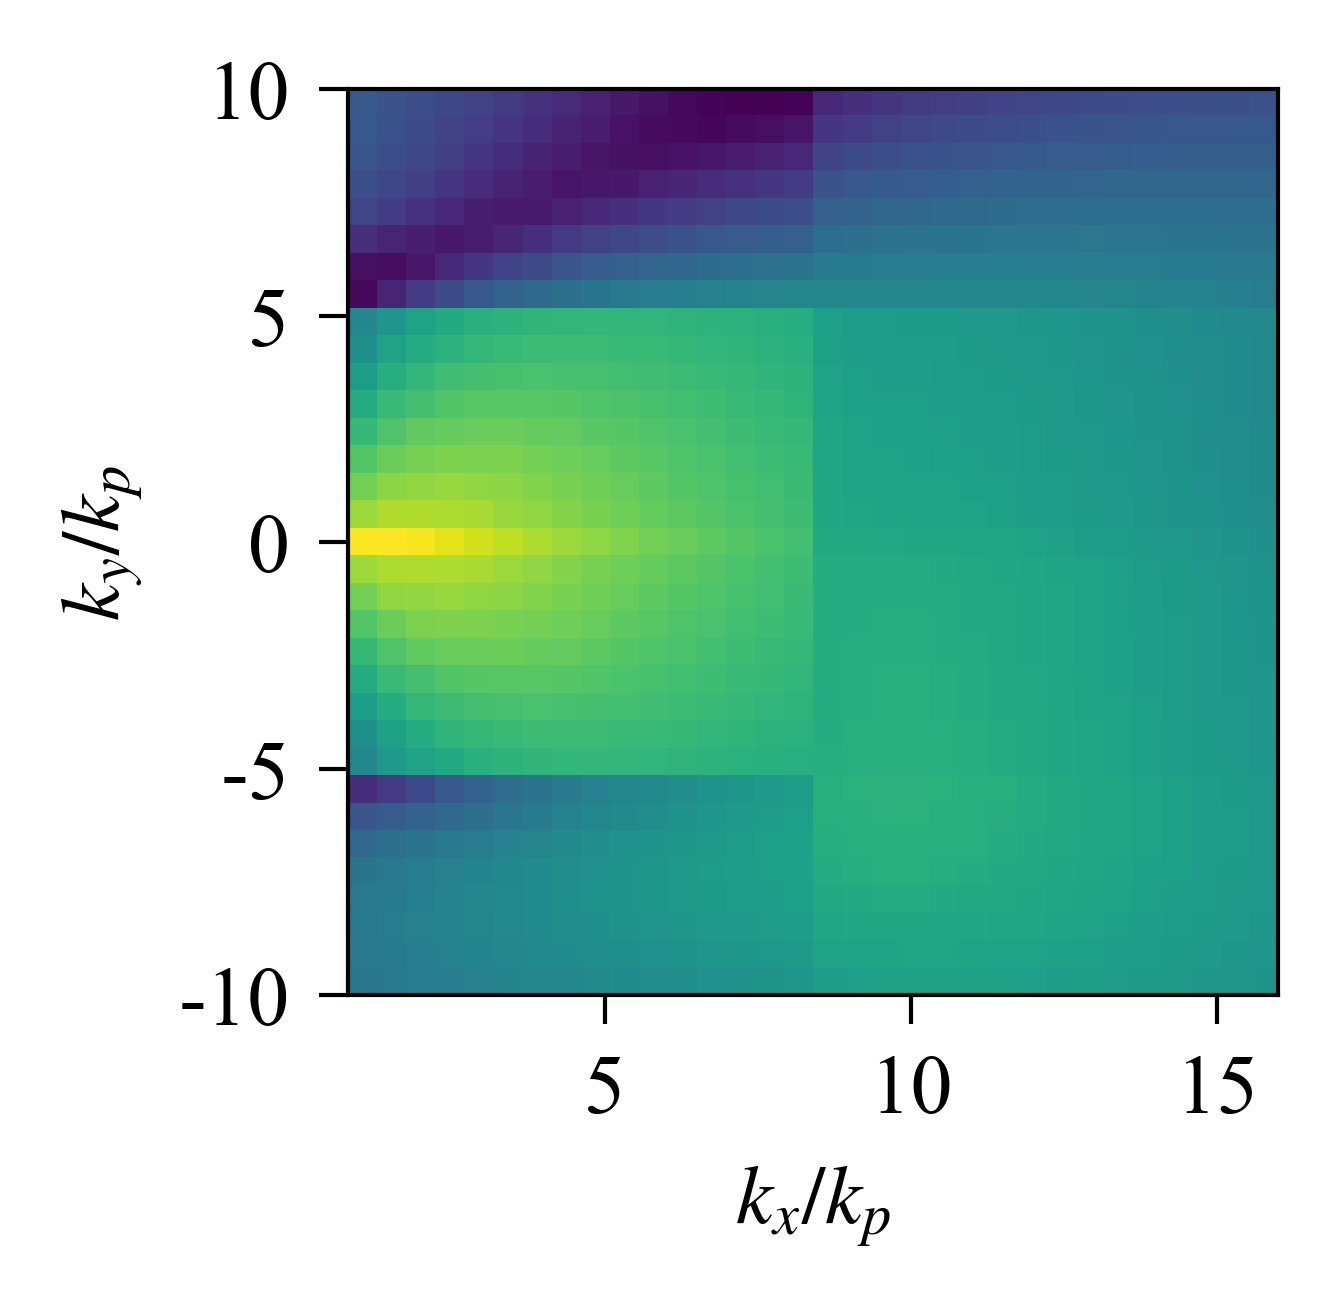

In [109]:
fig = plt.figure(figsize=[2,2])
kx_tile, ky_tile = np.meshgrid(kx,ky)
kp = 2*np.pi/40
# Some visualization:
plt.imshow(np.log(F_kxky_tile/F_kxky_tile.max()), extent=[kx_tile[0,0]/kp,kx_tile[-1,-1]/kp,ky_tile[0,0]/kp,ky_tile[-1,-1]/kp], aspect='auto')
plt.ylabel(r'$k_y/k_p$'); plt.xlabel(r'$k_x/k_p$')


kp*Hs from eta = 0.219745


(-0.5, 255.5, 255.5, -0.5)

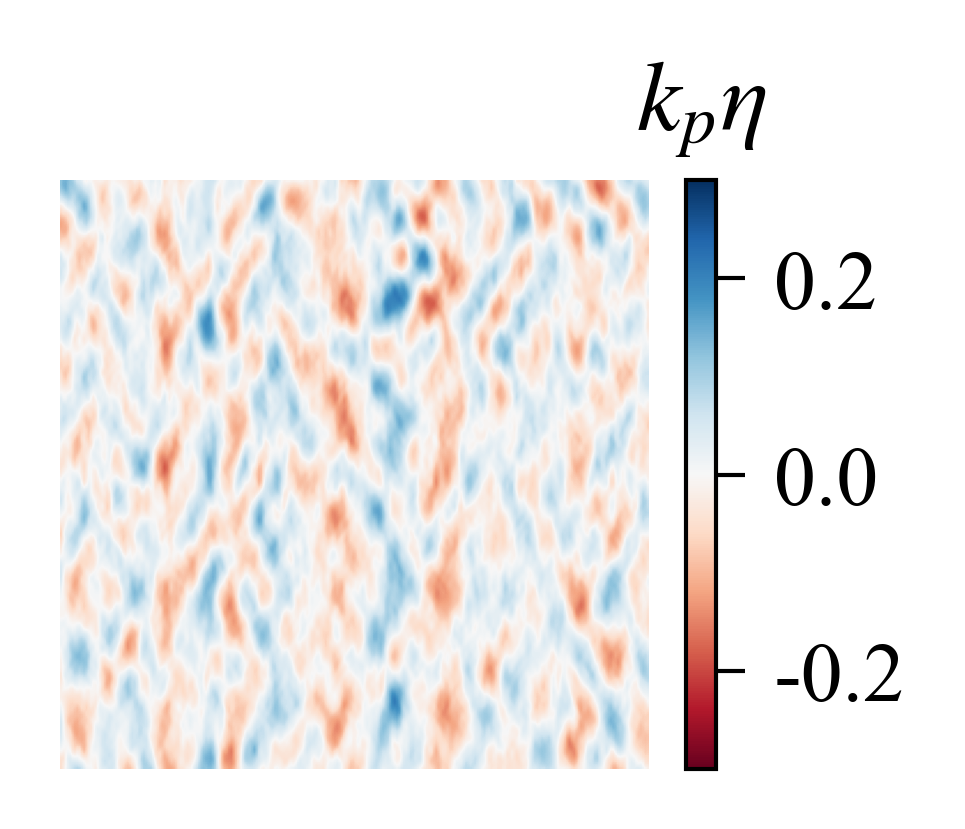

In [98]:
fig = plt.figure(figsize=[1.6,1.3])
N_grid = 256; L = 200
kp = 2*np.pi/(L/5)
x = np.linspace(-L/2,L/2,N_grid); y = np.linspace(-L/2,L/2,N_grid)
x_tile, y_tile = np.meshgrid(x, y)
kmod_cart_tile, theta_cart_tile = cart2pol(kx_tile,ky_tile)
omega_tile = (9.8*kmod_cart_tile)**0.5 # frequency based on kx or kmod
dkx = kx_tile[0,1]-kx_tile[0,0]; dky = ky_tile[1,0]-ky_tile[0,0]

eta_tile, phase_tile = eta_random(0, N_grid, kx_tile, ky_tile, F_kxky_tile, dkx, dky, omega_tile)
kpHs = np.var(eta_tile)**0.5*kp*4
print('kp*Hs from eta = %g' %kpHs)

image = plt.imshow(kp*eta_tile, vmax=0.3, vmin=-0.3, cmap='RdBu')
cbar = plt.colorbar(image); cbar.ax.set_title(r'$k_p\eta$') 
plt.axis('off')

kp*Hs from eta = 0.235288


(-0.5, 255.5, 255.5, -0.5)

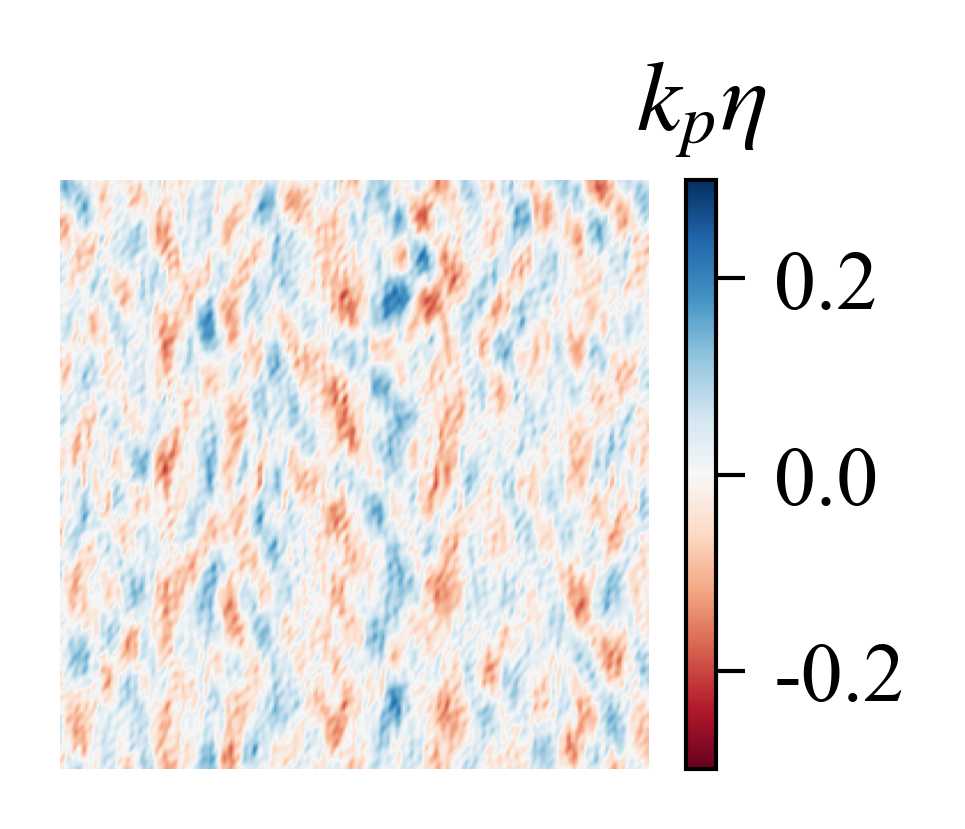

In [101]:
fig = plt.figure(figsize=[1.6,1.3])
N_grid = 256; L = 200
kp = 2*np.pi/(L/5)
x = np.linspace(-L/2,L/2,N_grid); y = np.linspace(-L/2,L/2,N_grid)
x_tile, y_tile = np.meshgrid(x, y)
kmod_cart_tile, theta_cart_tile = cart2pol(kx_tile,ky_tile)
omega_tile = (9.8*kmod_cart_tile)**0.5 # frequency based on kx or kmod
dkx = kx_tile[0,1]-kx_tile[0,0]; dky = ky_tile[1,0]-ky_tile[0,0]

eta_tile, phase_tile = eta_random(0, N_grid, kx_tile, ky_tile, F_kxky_tile, dkx, dky, omega_tile)
kpHs = np.var(eta_tile)**0.5*kp*4
print('kp*Hs from eta = %g' %kpHs)

image = plt.imshow(kp*eta_tile, vmax=0.3, vmin=-0.3, cmap='RdBu')
cbar = plt.colorbar(image); cbar.ax.set_title(r'$k_p\eta$') 
plt.axis('off')

In [10]:
def make_r_theta_vals(xs,ys,F_xy,ntheta=100,nr=100):    
    rmax = (xs.max()**2 + ys.max()**2)**0.5
    radii = np.linspace(0, rmax, nr, endpoint=True)
    thetas = np.linspace(0, 2*np.pi, ntheta, endpoint=True)
    r_tile, theta_tile = np.meshgrid(radii, thetas)
    xp_tile, yp_tile = pol2cart(r_tile, theta_tile) # The xs and ys correponding to the POLAR radii and thetas
    x_tile, y_tile = np.meshgrid(xs, ys)
    F_rtheta = griddata((x_tile.ravel(), y_tile.ravel()), F_xy.ravel(), (xp_tile, yp_tile), method='nearest')
    return radii, thetas, F_rtheta

/home/jiarongw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 432x288 with 0 Axes>

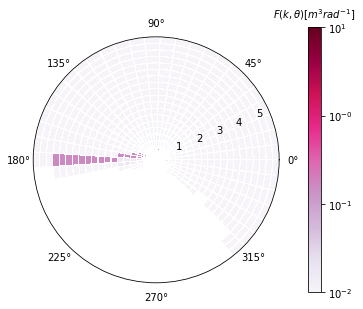

In [38]:
lim = 5
radii, thetas, F_rtheta = make_r_theta_vals(xs=kx[1:-lim],ys=ky[1:-lim],F_xy=F_kxky_tile[1:-lim,1:-lim],ntheta=50,nr=20)
ax = make_polar_plot(thetas, radii, np.log(F_rtheta))
# make_cartesian_plot(xs=kx,ys=ky,F_xy=F[100])

In [17]:
F_kxky_tile[lim:-lim,lim:-lim]

array([], shape=(0, 0), dtype=float64)

In [37]:
kx

array([0.03141593, 0.23308591, 0.43475589, 0.63642587, 0.83809585,
       1.03976583, 1.24143581, 1.44310579, 1.64477577, 1.84644575,
       2.04811573, 2.24978571, 2.45145569, 2.65312567, 2.85479565,
       3.05646563, 3.25813561, 3.45980559, 3.66147557, 3.86314555,
       4.06481553, 4.26648551, 4.46815549, 4.66982547, 4.87149545,
       5.07316543, 5.27483541, 5.47650539, 5.67817537, 5.87984535,
       6.08151533, 6.28318531])